## 0-Librairies

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import BatchNormalization, RandomRotation, RandomTranslation, RandomZoom, RandomBrightness
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.config import run_functions_eagerly
from tensorflow.keras import backend as K

In [99]:
run_functions_eagerly((True))

## 1 - Data Preparation

In [100]:
X_train = np.load("Images/train_images.npy") 
y_train = np.load("Images/train_labels.npy") 
X_test = np.load("Images/test_images.npy")  
y_test = np.load("Images/test_labels.npy")  

In [101]:
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data y_train:{y_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')
print(f'Shape of data y_test:{y_test.shape}')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data y_test:(10000,)


In [102]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [103]:
# Flatten images for dense model
X_train_flat = X_train.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)

## 2 - Data Viz

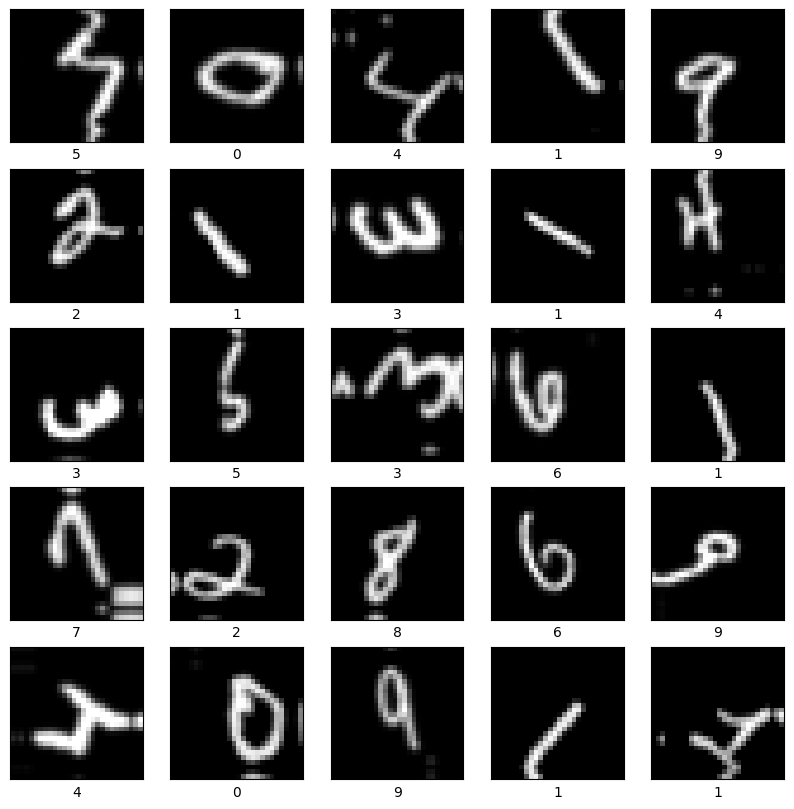

In [104]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(y_train[i])
plt.show()

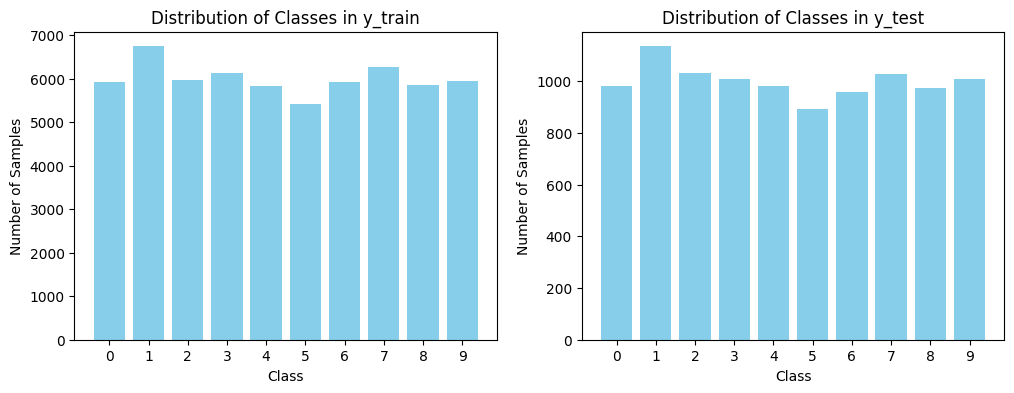

In [105]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, counts_train, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_train')
plt.xticks(unique_classes_train)  

plt.subplot(1, 2, 2)
plt.bar(unique_classes_test, counts_test, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_test')
plt.xticks(unique_classes_test)  
plt.show()

## 3 - Dense Modele

### Parameters

In [106]:
# Parameters
epochs_dense =  40
batch_size_dense = 64
validation_split_dense = .2
k_folds = 5
learning_rate_dense = 0.001
metric_dense = ["accuracy"]  # "SparseCategoricalAccuracy"    "accuracy"
monitor_callback_dense = "val_accuracy"
patience_callback_dense = 3
mode_callback_dense = "max"

### Modele

In [ ]:
def create_dense_model():
    dense_model = Sequential([
    Dense(64, activation='relu', input_shape=(784,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

    dense_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate_dense),
                    loss='sparse_categorical_crossentropy',
                    metrics=metric_dense
        )
    return dense_model

In [108]:
skf = StratifiedKFold(n_splits=k_folds, shuffle=True)
fold_results = []
best_dense_model = None
best_accuracy = 0.0
best_loss = 0.0
best_dense_history = None
best_histories = [(None, 0.0) for i in range (k_folds)]

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_flat, y_train)):
    print(f"\nFold {fold + 1}/{k_folds}")


    X_train_fold, X_val_fold = X_train_flat[train_idx], X_train_flat[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # New model for the current fold
    dense_model = create_dense_model()

    # Train the model
    history = dense_model.fit(
        X_train_fold, y_train_fold,
        epochs=epochs_dense,
        batch_size=batch_size_dense,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[EarlyStopping(monitor=monitor_callback_dense, patience=patience_callback_dense, mode=mode_callback_dense, restore_best_weights=True)],
        verbose=1
    )

    # Evaluate the model
    val_loss, val_accuracy = dense_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy:.4f}")

    # Store the results
    fold_results.append((val_accuracy, val_loss))

    if val_accuracy > best_histories[fold][1] :
        best_histories[fold] = (dense_model, val_accuracy, val_loss, history)

    # Kepp the best model
    if val_accuracy > best_accuracy :
        best_accuracy = val_accuracy
        best_loss = val_loss
        best_dense_model = dense_model
        best_dense_history = history


Fold 1/5


/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 69s 92ms/step - accuracy: 0.1712 - loss: 2.2164 - val_accuracy: 0.2184 - val_loss: 2.1356
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 70s 93ms/step - accuracy: 0.2131 - loss: 2.1307 - val_accuracy: 0.2303 - val_loss: 2.0814
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 69s 91ms/step - accuracy: 0.2252 - loss: 2.0893 - val_accuracy: 0.2508 - val_loss: 2.0323
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 68s 90ms/step - accuracy: 0.2365 - loss: 2.0611 - val_accuracy: 0.2649 - val_loss: 1.9930
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 72s 95ms/step - accuracy: 0.2498 - loss: 2.0287 - val_accuracy: 0.2842 - val_loss: 1.9396
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 70s 93ms/step - accuracy: 0.2658 - loss: 1.9907 - val_accuracy: 0.2945 - val_loss: 1.9086
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 89ms/step - accuracy: 0.2796 - loss: 1.9649 - val_accuracy: 0.3211 - val_loss: 1.8570
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 69s 92ms/step - accuracy: 0.2905 - loss: 1.9380 - 

In [109]:
# Print the result
print("\n--- Cross-Validation Results ---")
for i, (accuracy, loss) in enumerate(fold_results):
    print(f"Fold {i + 1}: Validation accuracy = {accuracy:.4f}")
    print(f"Fold {i + 1}: Validation loss = {loss:.4f}")

print(f"\nBest validation accuracy: {best_accuracy:.4f}")
print(f"\nBest validation loss: {best_loss:.4f}")

# Best Model
print("\nBest model summary:")
best_dense_model.summary()


accuracies = [result[0] for result in fold_results]
losses = [result[1] for result in fold_results]

# Variance and Mean
mean_accuracy = np.mean(accuracies)
variance_accuracy = np.var(accuracies, ddof=1)
std_accuracy = np.std(accuracies, ddof=1)

mean_loss = np.mean(losses)
variance_loss = np.var(losses, ddof=1)
std_loss = np.std(losses, ddof=1)


print(f"Mean of accuracies : {mean_accuracy:.4f}")
print(f"Variance of accuracies : {variance_accuracy:.6f}")
print(f"Std of accuracies : {std_accuracy:.4f}")

print(f"\nMean of losses : {mean_loss:.4f}")
print(f"Variance of losses : {variance_loss:.6f}")
print(f"Std of losses : {std_loss:.4f}")


--- Cross-Validation Results ---
Fold 1: Validation accuracy = 0.4243
Fold 1: Validation loss = 1.6643
Fold 2: Validation accuracy = 0.4288
Fold 2: Validation loss = 1.6578
Fold 3: Validation accuracy = 0.4773
Fold 3: Validation loss = 1.5269
Fold 4: Validation accuracy = 0.4162
Fold 4: Validation loss = 1.6899
Fold 5: Validation accuracy = 0.4548
Fold 5: Validation loss = 1.6021

Best validation accuracy: 0.4773

Best validation loss: 1.5269

Best model summary:


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,000 (1.27 MB)

 Trainable params: 110,666 (432.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 221,334 (864.59 KB)

Mean of accuracies : 0.4403
Variance of accuracies : 0.000636
Std of accuracies : 0.0252

Mean of losses : 1.6282
Variance of losses : 0.004233
Std of losses : 0.0651


### Results for the best fold

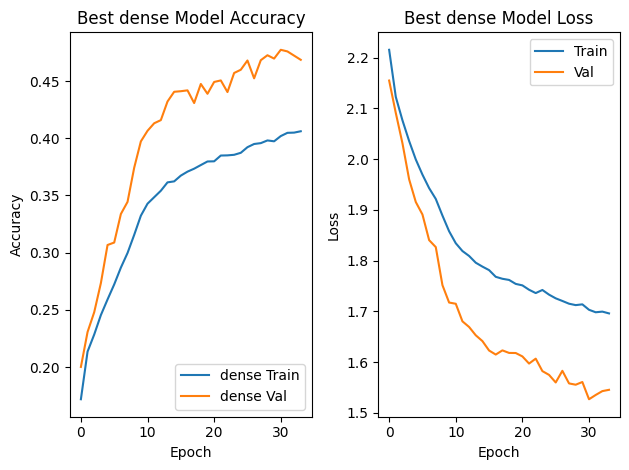

In [110]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(best_dense_history.history["accuracy"], label='dense Train')
plt.plot(best_dense_history.history['val_accuracy'], label='dense Val')
plt.title('Best dense Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(best_dense_history.history['loss'], label='Train')
plt.plot(best_dense_history.history['val_loss'], label='Val')
plt.title('Best dense Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [111]:
# Predict classes using the dense model
y_pred_dense = best_dense_model.predict(X_test_flat)
y_pred_classes_dense = np.argmax(y_pred_dense, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


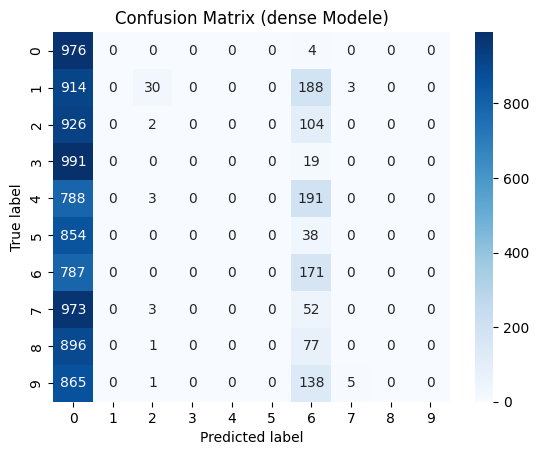

Class 0:
  Sensitivity (SEV): 0.9959
  Specificity (SPE): 0.1137
  Accuracy: 0.2002
  F1-score: 0.1962

Class 1:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.8865
  F1-score: 0.0000

Class 2:
  Sensitivity (SEV): 0.0019
  Specificity (SPE): 0.9958
  Accuracy: 0.8932
  F1-score: 0.0037

Class 3:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.8990
  F1-score: 0.0000

Class 4:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9018
  F1-score: 0.0000

Class 5:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9108
  F1-score: 0.0000

Class 6:
  Sensitivity (SEV): 0.1785
  Specificity (SPE): 0.9103
  Accuracy: 0.8402
  F1-score: 0.1763

Class 7:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9991
  Accuracy: 0.8964
  F1-score: 0.0000

Class 8:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9026
  F1-score: 0.0000

Class 9:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000

In [112]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_dense)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (dense Modele)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    accuracy = (tn + tp) / (tp + fn + tn + fp)
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-score: {f1:.4f}\n')

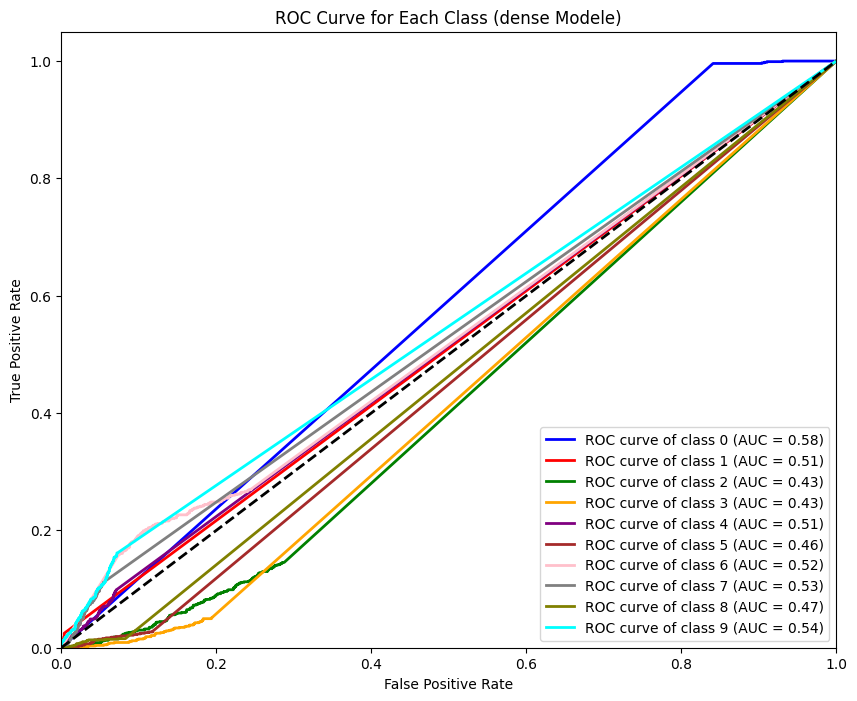

In [113]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_dense[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (dense Modele)')
plt.legend(loc="lower right")
plt.show()

### Results of all the folds

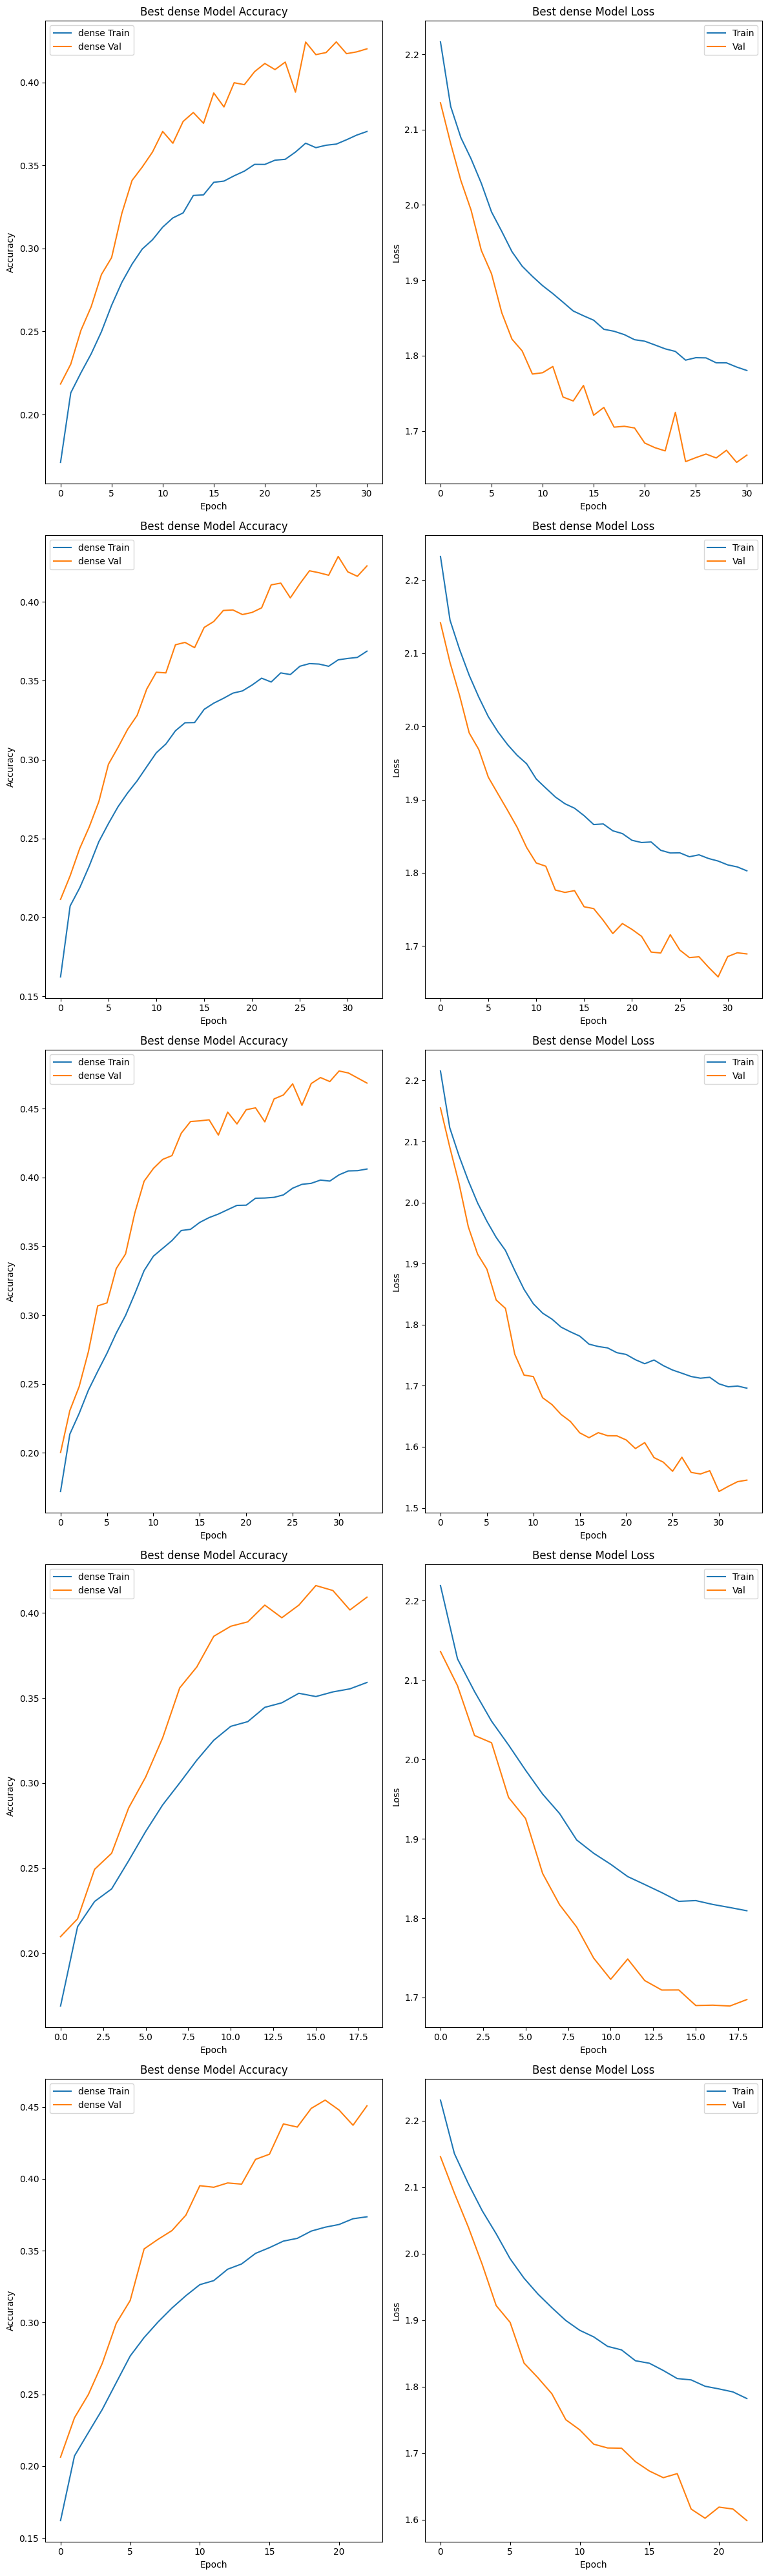

In [114]:
plt.figure(figsize=(12, 8*k_folds))
for fold in range (k_folds) :
    dense_model = best_histories[fold][3]
    # Accuracy
    plt.subplot(k_folds, 2, 2*fold+1)
    plt.plot(dense_model.history["accuracy"], label='dense Train')
    plt.plot(dense_model.history['val_' + "accuracy"], label='dense Val')
    plt.title('Best dense Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss
    plt.subplot(k_folds, 2, 2*fold+2)
    plt.plot(dense_model.history['loss'], label='Train')
    plt.plot(dense_model.history['val_loss'], label='Val')
    plt.title('Best dense Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
plt.show()


  4/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

-------- Fold 1: --------

Class 0:
  Sensitivity (SEV): 0.9939
  Specificity (SPE): 0.2573
  Accuracy: 0.3295
  F1-score: 0.2251

Class 1:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.8865
  F1-score: 0.0000

Class 2:
  Sensitivity (SEV): 0.0727
  Specificity (SPE): 0.8957
  Accuracy: 0.8108
  F1-score: 0.0735

Class 3:
  Sensitivity (SEV): 0.1158
  Specificity (SPE): 0.9314
  Accuracy: 0.8490
  F1-score: 0.1342

Class 4:
  Sensitivity (SEV): 0.0010
  Specificity (SPE): 0.9990
  Accuracy: 0.9010
  F1-score: 0.0020

Class 5:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9108
  F1-score: 0.0000

Class 6:
  Sensitivity (SEV): 0.0125
  Specificity (SPE): 0.9895
  Accuracy: 0.8959
  F1-score: 0.0225

Class 7:
  Sensitivity (SEV): 0.0837
  Specificity (SPE): 0.9827
  Accuracy: 0.8903
  F1-score: 0.1355

Class 8:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9990
  Accuracy: 0.9017
  F1-score: 0.0

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

-------- Fold 2: --------

Class 0:
  Sensitivity (SEV): 1.0000
  Specificity (SPE): 0.0157
  Accuracy: 0.1122
  F1-score: 0.1808

Class 1:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.8865
  F1-score: 0.0000

Class 2:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9993
  Accuracy: 0.8962
  F1-score: 0.0000

Class 3:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.8990
  F1-score: 0.0000

Class 4:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9999
  Accuracy: 0.9017
  F1-score: 0.0000

Class 5:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9108
  F1-score: 0.0000

Class 6:
  Sensitivity (SEV): 0.0052
  Specificity (SPE): 0.9883
  Accuracy: 0.8941
  F1-score: 0.0094

Class 7:
  Sensitivity (SEV): 0.0049
  Specificity (SPE): 0.9984
  Accuracy: 0.8963
  F1-score: 0.0096

Class 8:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9994
  Accuracy: 0.9021
  F1-score: 0.0

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

-------- Fold 3: --------

Class 0:
  Sensitivity (SEV): 0.9959
  Specificity (SPE): 0.1137
  Accuracy: 0.2002
  F1-score: 0.1962

Class 1:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.8865
  F1-score: 0.0000

Class 2:
  Sensitivity (SEV): 0.0019
  Specificity (SPE): 0.9958
  Accuracy: 0.8932
  F1-score: 0.0037

Class 3:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.8990
  F1-score: 0.0000

Class 4:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9018
  F1-score: 0.0000

Class 5:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9108
  F1-score: 0.0000

Class 6:
  Sensitivity (SEV): 0.1785
  Specificity (SPE): 0.9103
  Accuracy: 0.8402
  F1-score: 0.1763

Class 7:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9991
  Accuracy: 0.8964
  F1-score: 0.0000

Class 8:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9026
  F1-score: 0.0

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

-------- Fold 4: --------

Class 0:
  Sensitivity (SEV): 0.9990
  Specificity (SPE): 0.1041
  Accuracy: 0.1918
  F1-score: 0.1950

Class 1:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9997
  Accuracy: 0.8862
  F1-score: 0.0000

Class 2:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9997
  Accuracy: 0.8965
  F1-score: 0.0000

Class 3:
  Sensitivity (SEV): 0.0188
  Specificity (SPE): 0.9799
  Accuracy: 0.8828
  F1-score: 0.0314

Class 4:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9018
  F1-score: 0.0000

Class 5:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9108
  F1-score: 0.0000

Class 6:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9997
  Accuracy: 0.9039
  F1-score: 0.0000

Class 7:
  Sensitivity (SEV): 0.1702
  Specificity (SPE): 0.9447
  Accuracy: 0.8651
  F1-score: 0.2060

Class 8:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9997
  Accuracy: 0.9023
  F1-score: 0.0

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

-------- Fold 5: --------

Class 0:
  Sensitivity (SEV): 0.9265
  Specificity (SPE): 0.7578
  Accuracy: 0.7743
  F1-score: 0.4459

Class 1:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 0.9999
  Accuracy: 0.8864
  F1-score: 0.0000

Class 2:
  Sensitivity (SEV): 0.1395
  Specificity (SPE): 0.9492
  Accuracy: 0.8656
  F1-score: 0.1765

Class 3:
  Sensitivity (SEV): 0.1604
  Specificity (SPE): 0.8911
  Accuracy: 0.8173
  F1-score: 0.1506

Class 4:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9018
  F1-score: 0.0000

Class 5:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.9108
  F1-score: 0.0000

Class 6:
  Sensitivity (SEV): 0.7745
  Specificity (SPE): 0.7413
  Accuracy: 0.7445
  F1-score: 0.3674

Class 7:
  Sensitivity (SEV): 0.1196
  Specificity (SPE): 0.9911
  Accuracy: 0.9015
  F1-score: 0.1998

Class 8:
  Sensitivity (SEV): 0.1047
  Specificity (SPE): 0.9481
  Accuracy: 0.8660
  F1-score: 0.1

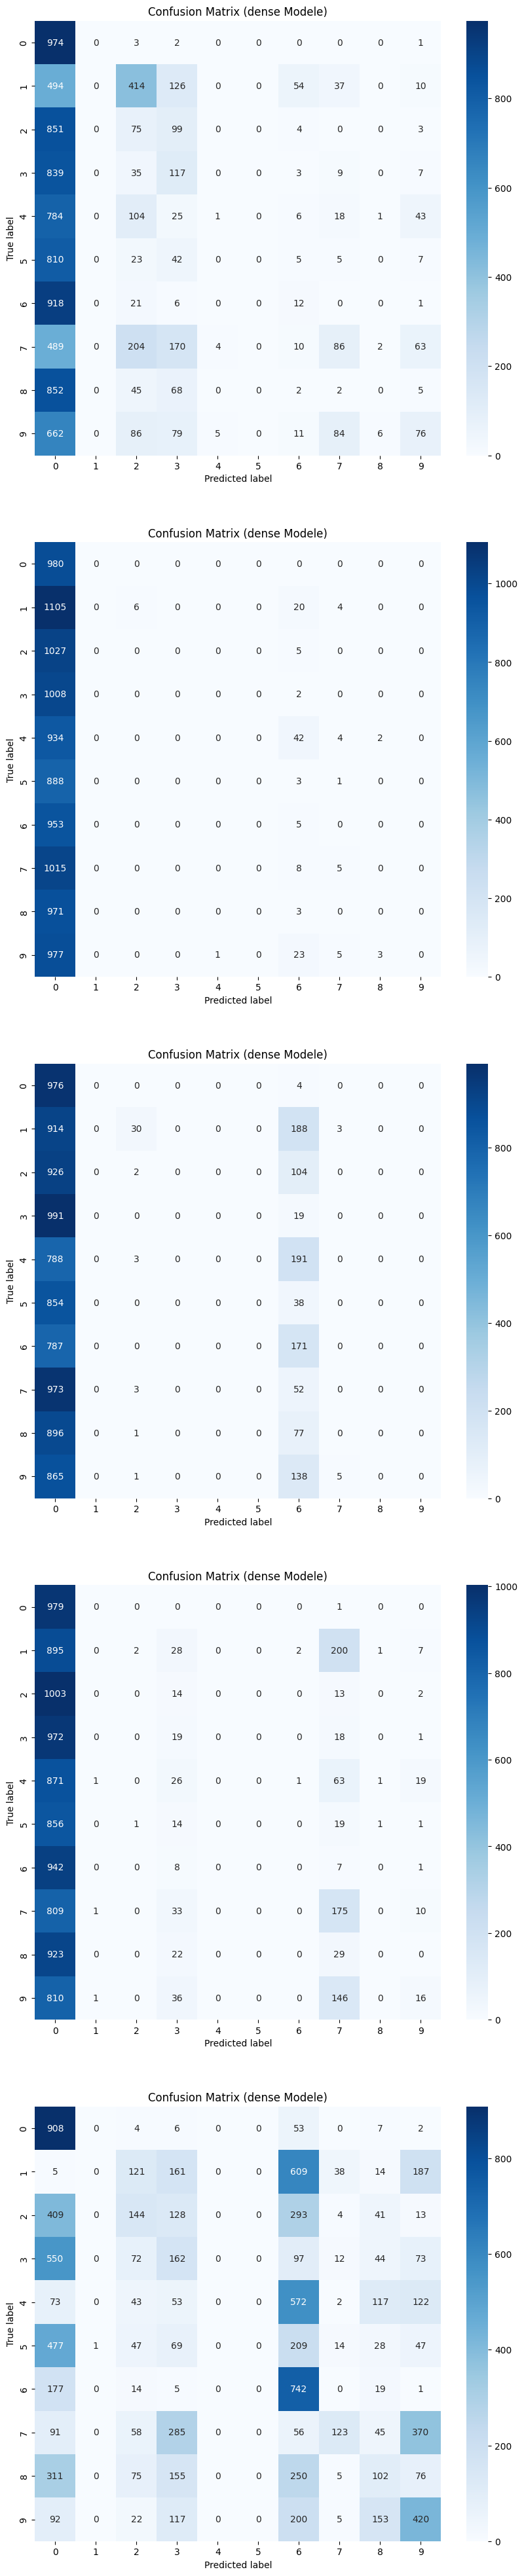

In [115]:
plt.figure(figsize=(10, 10*k_folds))
for fold in range (k_folds) :
    dense_model = best_histories[fold][0]
    y_pred_dense = dense_model.predict(X_test_flat)
    y_pred_classes_dense = np.argmax(y_pred_dense, axis=1)
    # Confusion matrix
    matrix = confusion_matrix(y_test, y_pred_classes_dense)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)
    
    plt.subplot(k_folds, 1, fold+1)
    # Plot confusion matrix
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix (dense Modele)')

    print(f"\n-------- Fold {fold + 1}: --------\n")

    # Calculate Sensitivity (SEV) and Specificity (SPE) for each class
    for i in range(matrix.shape[0]):
        tp = matrix[i, i]
        fn = np.sum(matrix[i, :]) - tp
        fp = np.sum(matrix[:, i]) - tp
        tn = np.sum(matrix) - tp - fn - fp
        f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
        sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
        spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
        accuracy = (tn + tp) / (tp + fn + tn + fp)
        print(f'Class {i}:')
        print(f'  Sensitivity (SEV): {sev:.4f}')
        print(f'  Specificity (SPE): {spe:.4f}')
        print(f'  Accuracy: {accuracy:.4f}')
        print(f'  F1-score: {f1:.4f}\n')

plt.show()

  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step 

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
  7/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step 

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
  9/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step  

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
  1/313 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 17/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


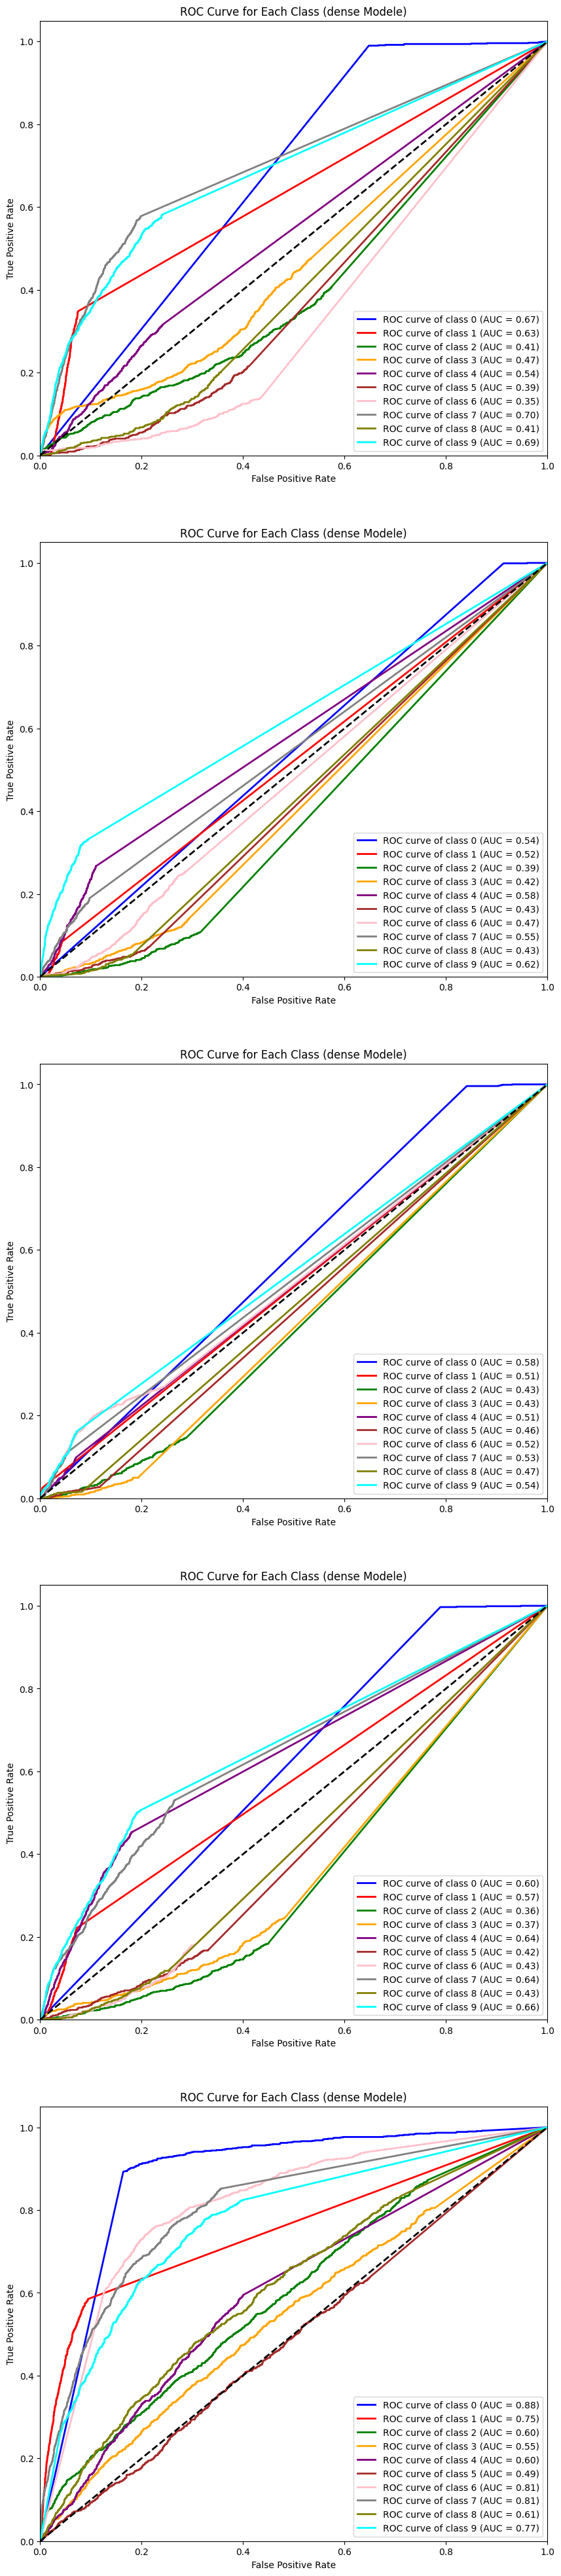

In [116]:
plt.figure(figsize=(10, 10*k_folds))

for fold in range (k_folds) :
    dense_model = best_histories[fold][0]
    y_pred_dense = dense_model.predict(X_test_flat)
    y_pred_classes_dense = np.argmax(y_pred_dense, axis=1)

    # Binarize the output for ROC curve (one-vs-rest)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_dense[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    plt.subplot(k_folds, 1, fold+1)

    # Plot ROC curves for each class
    #plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class (dense Modele)')
    plt.legend(loc="lower right")
plt.show()